# <font color= 'blue'> Deep Learning
# <font color='blue'> Project 3 </font>

## <font color= 'blue'> Recurrent Neural Network
### "A feedforward network with feedback"

Mehek Niwas || MTH 4320 Fall 2023

# <font color= 'blue'> Goals

*1) Use a recurrent neural network to classify a 1 second EEG recording into 1 of 5 classes*

*2) Maintain a computationally inexpensive model*

# <font color= 'blue'> Epileptic Seizure Recognition Dataset
This dataset was obtained from Kaggle, and originally found in the UCI Machine Learning Respository that has now been removed. Link: https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition

## Input: EEG Values
> Shape: 11,500 x 178

The dataset was taken from EEG recordings from 500 patients. The recordings were for 23 seconds. **Then, each second from each recording was vectorized into 178 datapoints of EEG values in order to maximize the full dataset.**

Therefore, the input matrix has 11,500 feature-vectors, or rows (23 seconds * 500 patients = 11,500).
**Each feature-vector consits of 178 EEG values to represent 1 second of an EEG recording.** The RNN will require 178 time steps.

Since each feature-vector only contains EEG values from 1 second and not all 23 seconds collected from a patient, there can be multiple feature-vectors that stem from a singular patient. <font color= 'purple'> ***This is why proper shuffling of the data is especially necessary for this project.***

## Output: Classification of Brain Activity
> Shape: 11,500 x 1

Each recording of 1 second is classified into one of 5 classes:

**1 - Seizure:** Brain activity is of a seizure

**2 - Tumor:** Brain activity is of a brain area containing a tumor

**3 - Healthy Area:** Brain activity is of a healthy brain area (not containing tumor)

**4 - Eyes Closed:** Brain activity is while patient's eyes were closed (no other classifications apply)

**5 - Eyes Open:** Brain activity is while patient's eyes were open (no other classifications apply)

# <font color= 'blue'> Data Preprocressing & Preparation
***Modifications:*** Dataset was mostly pre-procressed, but the original indexes and labels for patients were removed, and float type of the features was ensured.

***CUDA and Torch:*** I wanted to use tensors and CUDA in order to be able to run the network as fast as possible. I referred to code from https://github.com/ast0414/CSE6250BDH-LAB-DL/blob/master/3_RNN.ipynb to prepare the data and learn how to set up a RNN with torch and CUDA integration. I also used two different ways of making sure GPU is running/being used.

***Randomization & Reproducibility***: `train_test_split` was used to randomize the data for training, validation, and test splits from a csv. It was then converted into a torch dataloader object for easy implementation of batches in later experiments of the project.

However, I needed a way to be able to access these tensor splits in later runtime sessions since this was a multi-day project:
- created function to convert train/valid/test splits into csv for storage on personal device
- created function convert to train/valid/test csv into torch dataloader object

This allowed for use of the exact same randomized split for every session of this project

Note: I also included the code relating to functions for training, graphing, and accuracy of a potential model under this section




### gpu, cuda, torch checking


In [ ]:
#!nvidia-smi # making sure GPU is running

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
  print(tf.test.gpu_device_name())
  print(device_lib.list_local_devices()[1].physical_device_desc)

# check if cuda is available
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available. Using CPU.")

Num GPUs Available:  1
/device:GPU:0
device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
CUDA is available!


In [ ]:
# imports
import time
import torch
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import torch.optim as optim

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

### dataset splits (60%, 20%, 20%)

In [ ]:
# had to run this twice to get correct numbers for some reason
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('Epileptic_Seizure_Recognition.csv')
labels = df['y'].values
labels = labels - 1
data = df.loc[:, 'X1':'X178'].values

X_train, X_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.4, random_state=6250)

# RANDOM STATE SPECIFICATION ALLOWS FOR REPRODUCILIBILITY OF THE RANDOMIZATION

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=6250)

print(X_train)
print("")
print("Training: 60%"); print("Inputs Training Shape: ", X_train.shape); print("Outputs Training Shape: ",y_train.shape); print("")
print("Validation: 20%"); print("Inputs Validation Shape: ", X_valid.shape); print("Outputs Validation Shape: ", y_valid.shape); print("")
print("Testing: 20% "); print("Inputs Testing Shape: ", X_test.shape); print("Outputs Testing Shape: ", y_test.shape); print("")

[[ 153  105   84 ... -775 -526 -312]
 [ 187  204  -15 ...  341  321  277]
 [ -49  -41  -35 ...   20   19   18]
 ...
 [ -38  -41  -49 ...    1    1    4]
 [ -18  -12   -8 ...  -62  -61  -61]
 [ -38  -33  -29 ...    6    9   15]]

Training: 60%
Inputs Training Shape:  (6900, 178)
Outputs Training Shape:  (6900,)

Validation: 20%
Inputs Validation Shape:  (2300, 178)
Outputs Validation Shape:  (2300,)

Testing: 20% 
Inputs Testing Shape:  (2300, 178)
Outputs Testing Shape:  (2300,)



### torch dataloader with batches

In [ ]:
# using torch dataloader

# MANUAL SEED SPECIFICATION ALLOWS FOR REPRODUCILIBILITY OF THE RANDOMIZATION
torch.manual_seed(6250)
if torch.cuda.is_available():
    torch.cuda.manual_seed(6250)

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(2), torch.from_numpy(y_train.astype('long')))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(2), torch.from_numpy(y_valid.astype('long')))
validloader = torch.utils.data.DataLoader(validset, batch_size=10, shuffle=False, num_workers=2)

testset = TensorDataset(torch.from_numpy(X_test.astype('float32')).unsqueeze(2), torch.from_numpy(y_test.astype('long')))
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen')

In [ ]:
# FOR BENCHMARK MODEL --> ONE BATCH ONLY
# use 6900 batch size so that all of training data is in 1 batch

# using torch dataloader
torch.manual_seed(6250)
if torch.cuda.is_available():
    torch.cuda.manual_seed(6250)

trainset = TensorDataset(torch.from_numpy(X_train.astype('float32')).unsqueeze(2), torch.from_numpy(y_train.astype('long')))
# syntax --> TensorDataset(data, labels)
trainB = torch.utils.data.DataLoader(trainset, batch_size=6900, shuffle=True, num_workers=2)

validset = TensorDataset(torch.from_numpy(X_valid.astype('float32')).unsqueeze(2), torch.from_numpy(y_valid.astype('long')))
validB = torch.utils.data.DataLoader(validset, batch_size=2300, shuffle=False, num_workers=2)

for batch_idx, (inputs, targets) in enumerate(trainB):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)

for batch_idx, (inputs, targets) in enumerate(validB):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)

Batch 0:
Inputs shape: torch.Size([6900, 178, 1])
Targets shape: torch.Size([6900])
Batch 0:
Inputs shape: torch.Size([2300, 178, 1])
Targets shape: torch.Size([2300])


### dataloader and csv conversion functions

In [ ]:
# only needs to be run ONCE after train test splits have been done in the very 1st runtime session!!
def dataloader_to_csv(loader, filename):
    data = []
    for inputs, targets in loader:
        for i in range(len(inputs)):
            row = list(inputs[i].flatten().numpy()) + [targets[i].item()]
            data.append(row)
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False, header=False)

dataloader_to_csv(trainB, "train_benchmark_data.csv")
dataloader_to_csv(trainloader, "train_data.csv")
dataloader_to_csv(validloader, "valid_data.csv")
dataloader_to_csv(testloader, "test_data.csv")

In [ ]:
# must be run in beginning of very runtime session to get same data splits from previous sessions
def csv_to_dataloader(filename, batch_size, shuffle):
    df = pd.read_csv(filename, header=None)
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    dataset = TensorDataset(torch.from_numpy(X.astype('float32')).unsqueeze(2), torch.from_numpy(y.astype('long')))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

trainB = csv_to_dataloader("train_benchmark_data.csv", 6900, False)
trainloader = csv_to_dataloader("train_data.csv", 10, False)
validloader = csv_to_dataloader("valid_data.csv", 10, False)
testloader = csv_to_dataloader("test_data.csv", 10, False)
print("csv to dataloader conversions completed!")

csv to dataloader conversions completed!


In [ ]:
classes = ('Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen')

In [ ]:
# checking size
for batch_idx, (inputs, targets) in enumerate(trainB):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)

Batch 0:
Inputs shape: torch.Size([6900, 178, 1])
Targets shape: torch.Size([6900])


### training and performance metric functions for models

In [ ]:
# training function
# loss function and optimizer defined by user outside of function

def train_and_graph(model, trainloader, validloader, maxEpoch, criterion, optimizer):
# model and criterion/optimizer model need to match in order for model to train properly

  cuda = torch.cuda.is_available()
  if cuda:
    model = model.cuda()

  train_losses = []
  valid_losses = []

  training_Start = time.time() # have to import time

  for epoch in range(maxEpoch):

    # set the model as train mode
    model.train()
    train_loss = 0.0
    train_counter = 0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, targets = data

      if cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += (loss.item() * inputs.size(0))
      train_counter += inputs.size(0)

    train_losses.append(train_loss/train_counter)

    # switch to evaluation mode
    model.eval()
    valid_loss = 0.0
    valid_counter = 0
    with torch.no_grad():
      for i, data in enumerate(validloader, 0):
        # get the inputs
        inputs, targets = data

        if cuda:
          inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        valid_loss += (loss.item() * inputs.size(0))
        valid_counter += inputs.size(0)
    valid_losses.append(valid_loss/valid_counter)

  training_End = time.time()
  print('Finished Training')
  print('Runtime: ', (training_End - training_Start))

  # graph training and validation loss with respect to epoch
  %matplotlib inline
  plt.figure()
  plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
  plt.plot(np.arange(len(valid_losses)), valid_losses, label='Validation')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(loc="best")

*   Precision `= true pos / true pos + false pos`. The closer precision is to 1, the less false positives there are.
*   Recall `= true pos / true pos + false neg` . The closer recall is to 1, the less false negatives there are.

F1 score is calculated by taking a harmonic mean of the precision and recall.

In [ ]:
def get_accuracy_RP(model, classes, dataloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  class_correct = list(0. for _ in range(len(classes))); class_total = list(0. for _ in range(len(classes)))
  class_TP = list(0. for _ in range(len(classes)))
  class_FP = list(0. for _ in range(len(classes)))
  class_FN = list(0. for _ in range(len(classes)))
  total_correct = 0; total_samples = 0
  overall_precision = 0; overall_recall = 0

  with torch.no_grad():
    for data in dataloader:
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)

      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      c = (predicted == targets).squeeze()

      total_correct += c.sum().item()
      total_samples += targets.size(0)

      for i, label in enumerate(targets):
        class_correct[label] += c[i].item()
        class_total[label] += 1

        if predicted[i] == label:
          class_TP[label] += 1
        else:
          class_FP[predicted[i]] += 1
          class_FN[label] += 1


  for i in range(len(classes)):
    currentPortion = class_total[i] / total_samples

    precision = class_TP[i] / (class_TP[i] + class_FP[i] + 1e-8)  # Adding a small value to avoid division by zero
    recall = class_TP[i] / (class_TP[i] + class_FN[i] + 1e-8)
    accuracy = 100 * class_correct[i] / class_total[i]

    overall_precision += (currentPortion * precision); overall_recall += (currentPortion * recall)
    print('{} Accuracy = {:.2f}%   P = {:.2f}   R = {:.2f}'.format(classes[i], accuracy, precision, recall))

  overall_accuracy = 100 * total_correct / total_samples
  print("-----------------------------------------------------")
  print("Overall Accuracy: {:.2f}%".format(overall_accuracy))
  #print("Overall Precision: {:.2f}".format(overall_precision)) -->
  #print("Overall Recall: {:.2f}".format(overall_recall)) -->
  #  .2f ensures truncation/rounding to 2 decimal places

# <font color= 'blue'> Experiment 0: Unmodified Model / Benchmark Classifer
*Architecture*:
- RNN cell
- layers = 1; dropout = 0.0; batches = 1; hidden_size = 32


*Results*: Accuracy is very low. Not much overfitting.

In [ ]:
# define rnn class

class RecurNet(nn.Module):
  def __init__(self):
    super(RecurNet, self).__init__()
    self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True, dropout=0.0)
    # input_size --> how many features per time step? (for current dataset, there are 178 per time step)

    # nn.GRUCell used for constructing complex architecture between gru layers

    self.fc = nn.Linear(in_features=32, out_features=5)
    # in_features --> match hidden_size
    # out_features --> match # of categories/classes

  def forward(self, x):
    # Forward pass through the RNN layer
    h_0 = torch.zeros(1, x.size(0), 32).to(x.device)  # Initial hidden state
    x, _ = self.rnn(x, h_0)  # Pass input and initial hidden state through RNN
    # Only using the output of the last time step for classification
    x = self.fc(x[:, -1, :])
    return x
    #x, _ = self.rnn(x)
    #x = self.fc(x[:, -1, :])
    #return x


In [ ]:
model = RecurNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  9.91720461845398


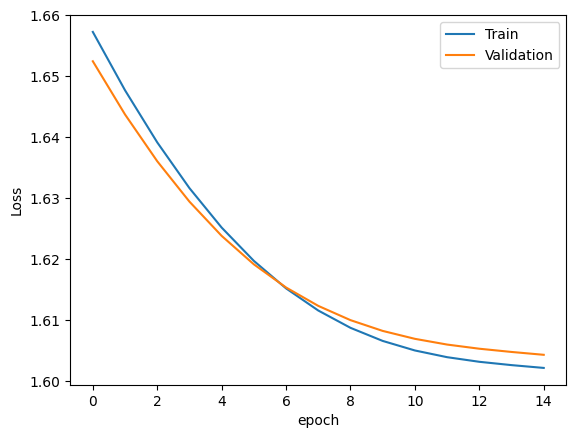

In [ ]:
maxEpoch = 15
# using training set version with only 1 batch that contain entirety of data
train_and_graph(model, trainB, validB, maxEpoch, criterion, optimizer)

In [ ]:
get_accuracy_RP(model, classes, trainB)

Class:  Seizure  --- 1436  cases
Accuracy = 22.98%   P = 0.14   R = 0.23

Class:  TumorArea  --- 1361  cases
Accuracy = 27.33%   P = 0.17   R = 0.27

Class:  HealthyArea  --- 1372  cases
Accuracy = 0.36%   P = 0.07   R = 0.00

Class:  EyesClosed  --- 1357  cases
Accuracy = 3.91%   P = 0.22   R = 0.04

Class:  EyesOpen  --- 1374  cases
Accuracy = 30.20%   P = 0.21   R = 0.30

-----------------------------------------------------
Overall Accuracy: 17.03%
Overall Precision: 0.16%
Overall Recall: 0.17%


# <font color= 'blue'> Experiment 1: Variations of RNNs [GRU vs. LSTM]
*Results:*
- GRU is better because of runtime
- GRU has more overfitting, yet around same results.
- LSTM has 0% accuracy on Eyes Open
- Loss rate of change looks to be constant

This makes sense since (in theory) GRU is suited towards a smaller number of time steps, whereas LSTM should perform better on longer time series data. **GRU cell will be used for rest of experiments.**

## <font color= 'black'> Basic GRU Model
- GRU cell
- layers = 1; dropout = 0.0; batches = 1; hidden_size = 32

In [ ]:
# define rnn class
# using gru as recurrent layer
#DO NOT RUN AGAIN

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=1, batch_first=True, dropout=0.0) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

In [ ]:
model = RecurNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  14.873963594436646


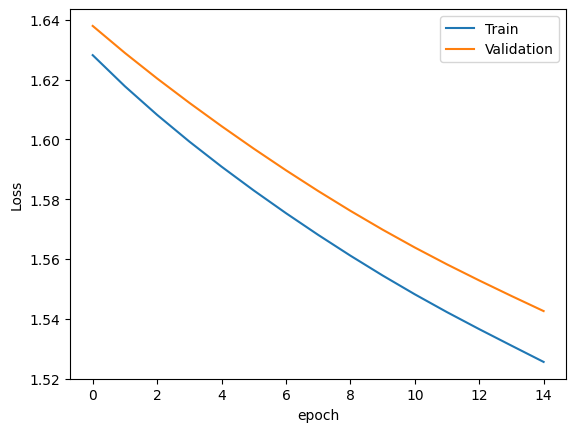

In [ ]:
maxEpoch = 15 # NO BATCHES
#DO NOT RUN AGAIN
train_and_graph(model, trainB, validloader, maxEpoch, criterion, optimizer)

In [ ]:
#DO NOT RUN AGAIN
print("Training Dataset: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset: 
Seizure Accuracy = 91.36%   P = 0.31   R = 0.91
TumorArea Accuracy = 23.37%   P = 0.33   R = 0.23
HealthyArea Accuracy = 13.34%   P = 0.34   R = 0.13
EyesClosed Accuracy = 8.84%   P = 0.27   R = 0.09
EyesOpen Accuracy = 12.88%   P = 0.24   R = 0.13
-----------------------------------------------------
Overall Accuracy: 30.58%
Overall Precision: 0.30
Overall Recall: 0.31

Validation Dataset: 
Seizure Accuracy = 91.53%   P = 0.28   R = 0.92
TumorArea Accuracy = 22.73%   P = 0.33   R = 0.23
HealthyArea Accuracy = 12.37%   P = 0.32   R = 0.12
EyesClosed Accuracy = 7.05%   P = 0.24   R = 0.07
EyesOpen Accuracy = 16.16%   P = 0.27   R = 0.16
-----------------------------------------------------
Overall Accuracy: 28.43%
Overall Precision: 0.29
Overall Recall: 0.28


## Basic LSTM Model
- LSTM cell
- layers = 1; dropout = 0.0; batches = 1; hidden_size = 32


In [ ]:
# DO NOT RUN AGAIN
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True, dropout=0.0) # using LSTM instead of GRU
        self.fc = nn.Linear(in_features=32, out_features=5)

    def forward(self, x):
        # LSTM returns both output and hidden state, so we unpack both
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

# defining loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  21.60550618171692


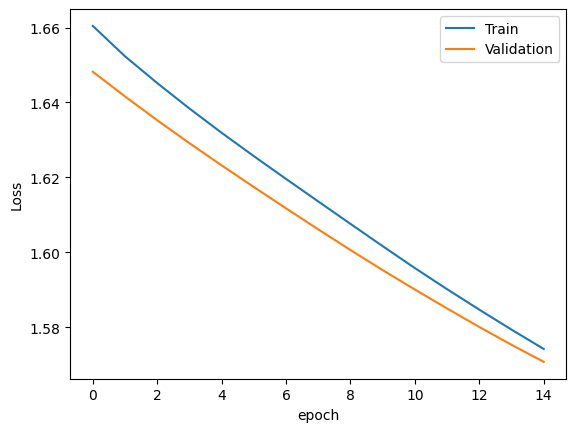

In [ ]:
maxEpoch = 15 # NO BATCHES
# DO NOT RUN AGAIN
train_and_graph(model, trainB, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset: 
Seizure Accuracy = 45.75%   P = 0.61   R = 0.46
TumorArea Accuracy = 40.12%   P = 0.21   R = 0.40
HealthyArea Accuracy = 43.08%   P = 0.25   R = 0.43
EyesClosed Accuracy = 13.85%   P = 0.20   R = 0.14
EyesOpen Accuracy = 0.00%   P = 0.00   R = 0.00
-----------------------------------------------------
Overall Accuracy: 28.72%
Overall Precision: 0.26
Overall Recall: 0.29

Validation Dataset: 
Seizure Accuracy = 45.28%   P = 0.57   R = 0.45
TumorArea Accuracy = 41.32%   P = 0.24   R = 0.41
HealthyArea Accuracy = 44.65%   P = 0.26   R = 0.45
EyesClosed Accuracy = 18.38%   P = 0.27   R = 0.18
EyesOpen Accuracy = 0.00%   P = 0.00   R = 0.00
-----------------------------------------------------
Overall Accuracy: 29.83%
Overall Precision: 0.26
Overall Recall: 0.30


# <font color= 'blue'> Experiment 2: Dropout Rate
- increased to 25 epochs to better observe effect of dropout
- 2 layers; dropout rate requires 2 layers
- 1 batch only

*Results:* 0.5 dropout has highest accuracy, 1 second longer runtime. Significantly decreased overfitting. However, loss rate of change is still constant

## Dropout: 0.2
Training Accuracy: 32.87
Validation Accuracy: 29.52

Overfitting has increased, slight improvement in accuracy


In [ ]:
# define rnn class
# using gru as recurrent layer

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.2) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  10.54385781288147


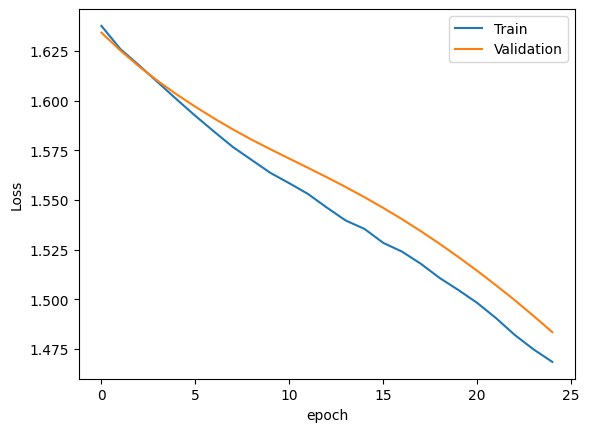

In [ ]:
maxEpoch = 25 # NO BATCHES
# DO NOT RUN AGAIN
train_and_graph(model, trainB, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainB)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 95.47%   P = 0.34   R = 0.95
TumorArea Accuracy = 18.30%   P = 0.36   R = 0.18
HealthyArea Accuracy = 7.51%   P = 0.40   R = 0.08
EyesClosed Accuracy = 6.48%   P = 0.37   R = 0.06
EyesOpen Accuracy = 33.26%   P = 0.27   R = 0.33
-----------------------------------------------------
Overall Accuracy: 32.87%
Overall Precision: 0.35
Overall Recall: 0.33

Validation Dataset Accuracy: 
Seizure Accuracy = 95.88%   P = 0.31   R = 0.96
TumorArea Accuracy = 15.91%   P = 0.31   R = 0.16
HealthyArea Accuracy = 7.76%   P = 0.39   R = 0.08
EyesClosed Accuracy = 7.69%   P = 0.38   R = 0.08
EyesOpen Accuracy = 29.04%   P = 0.23   R = 0.29
-----------------------------------------------------
Overall Accuracy: 29.52%
Overall Precision: 0.33
Overall Recall: 0.30


## <font color= 'black'> Dropout: 0.5
Training Accuracy: 39.51%
Validation Accuracy: 36.35%

Overfitting significantly decreased, significant increase in accuracy.
May try to increase dropout more after experimentation with other techniques. Loss rate of change still looks constant

In [ ]:
# define rnn class
# using gru as recurrent layer

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  11.698734045028687


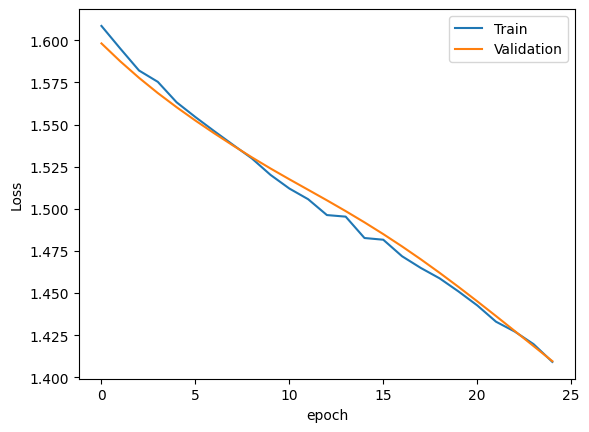

In [ ]:
maxEpoch = 25 # NO BATCHES
# DO NOT RUN AGAIN
train_and_graph(model, trainB, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainB)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 88.44%   P = 0.50   R = 0.88
TumorArea Accuracy = 39.53%   P = 0.34   R = 0.40
HealthyArea Accuracy = 37.10%   P = 0.32   R = 0.37
EyesClosed Accuracy = 16.21%   P = 0.33   R = 0.16
EyesOpen Accuracy = 13.76%   P = 0.40   R = 0.14
-----------------------------------------------------
Overall Accuracy: 39.51%
Overall Precision: 0.38
Overall Recall: 0.40

Validation Dataset Accuracy: 
Seizure Accuracy = 89.35%   P = 0.45   R = 0.89
TumorArea Accuracy = 37.40%   P = 0.33   R = 0.37
HealthyArea Accuracy = 35.22%   P = 0.30   R = 0.35
EyesClosed Accuracy = 14.32%   P = 0.29   R = 0.14
EyesOpen Accuracy = 11.14%   P = 0.34   R = 0.11
-----------------------------------------------------
Overall Accuracy: 36.35%
Overall Precision: 0.34
Overall Recall: 0.36


# <font color= 'blue'> Experiment 3: Batch Size
Went back down to 15 epochs
- 0.5 dropout w/ batch size 10
- 0.5 dropout w/ batch size 50
- 0.5 dropout w/ batch size 25
- 0.5 dropout w/ batch size 15

*Results:* Batch size 10 showed the highest accuracy. Batch size 15 accuracy compared to batch size 10 was only around 0.05 less.
Batch size 15 runtime was significantly shorter (22 seconds vs. 39 seconds)

Throughout the experiment, the trend seemed to show that decreasing batch size increases computation time at a much faster rate than accuracy/overfitting. A sweet spot between computation and performance can be found after some trial and error.

## <font color= 'black'> Batch Size: 10
Train Accuracy: 74%
Val Accuracy: 70.26%
- Accuracy for Tumor Area is lowest

Huge increase in accuracy, slight overfitting. Runtime increase.
Introduction of noise from batches is apparent when looking at loss graph.
Loss progression more closely resembles exponential decay due to batches... sign of faster convergence

In [ ]:
# define rnn class
# using gru as recurrent layer

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  39.4849157333374


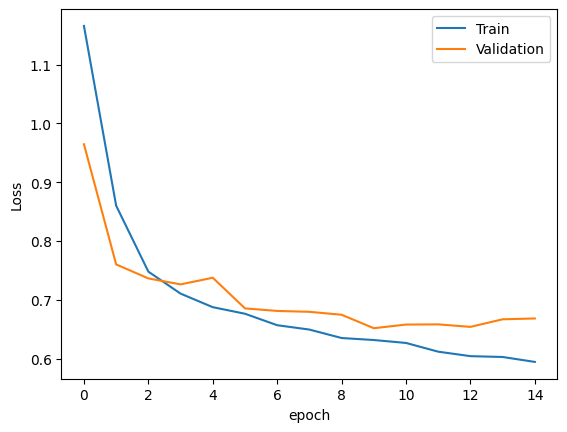

In [ ]:
maxEpoch = 15
# DO NOT RUN AGAIN
# initial trainloader is already in batches of 10
train_and_graph(model, trainloader, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainB)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 95.68%   P = 0.97   R = 0.96
TumorArea Accuracy = 39.31%   P = 0.65   R = 0.39
HealthyArea Accuracy = 74.56%   P = 0.57   R = 0.75
EyesClosed Accuracy = 77.60%   P = 0.81   R = 0.78
EyesOpen Accuracy = 81.59%   P = 0.72   R = 0.82
-----------------------------------------------------
Overall Accuracy: 74.00%
Overall Precision: 0.75
Overall Recall: 0.74

Validation Dataset Accuracy: 
Seizure Accuracy = 93.95%   P = 0.95   R = 0.94
TumorArea Accuracy = 35.12%   P = 0.60   R = 0.35
HealthyArea Accuracy = 71.91%   P = 0.53   R = 0.72
EyesClosed Accuracy = 76.92%   P = 0.80   R = 0.77
EyesOpen Accuracy = 77.51%   P = 0.69   R = 0.78
-----------------------------------------------------
Overall Accuracy: 70.26%
Overall Precision: 0.71
Overall Recall: 0.70


## <font color= 'black'> Batch Size: 50
Training Accuracy: 70.75%
Validation Accuracy: 67.17%
- Runtime is significantly lower (15 seconds vs. 39 seconds)

Accuracy is not as good as batch size 10, but still significant improvement. Overfitting starts to increase towards end of run.
Exponential loss graph.

Should maybe try batch size of 25 for faster runtime, yet similar results from batch size 10?

In [ ]:
# define rnn class
# using gru as recurrent layer

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# make batch size from train dataset csv
trainloader50 = csv_to_dataloader("train_data.csv", 50, False)

# checking batch size
for batch_idx, (inputs, targets) in enumerate(trainloader50):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)
  break  # Stop the loop after processing one batch

Batch 0:
Inputs shape: torch.Size([50, 178, 1])
Targets shape: torch.Size([50])


Finished Training
Runtime:  9.60822081565857


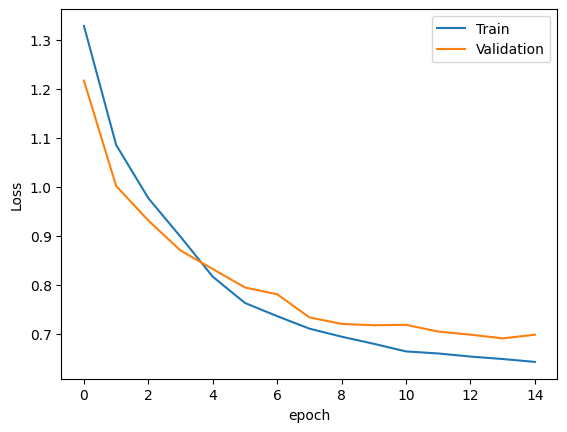

In [ ]:
maxEpoch = 15
# DO NOT RUN AGAIN
# initial trainloader is already in batches of 10
train_and_graph(model, trainloader50, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 94.78%   P = 0.94   R = 0.95
TumorArea Accuracy = 27.92%   P = 0.56   R = 0.28
HealthyArea Accuracy = 61.81%   P = 0.53   R = 0.62
EyesClosed Accuracy = 72.37%   P = 0.80   R = 0.72
EyesOpen Accuracy = 88.65%   P = 0.63   R = 0.89
-----------------------------------------------------
Overall Accuracy: 69.41%
Overall Precision: 0.69
Overall Recall: 0.69

Validation Dataset Accuracy: 
Seizure Accuracy = 94.19%   P = 0.93   R = 0.94
TumorArea Accuracy = 25.21%   P = 0.54   R = 0.25
HealthyArea Accuracy = 61.84%   P = 0.51   R = 0.62
EyesClosed Accuracy = 72.65%   P = 0.80   R = 0.73
EyesOpen Accuracy = 87.12%   P = 0.62   R = 0.87
-----------------------------------------------------
Overall Accuracy: 67.17%
Overall Precision: 0.67
Overall Recall: 0.67


## <font color= 'black'> Batch Size: 25
Training Accuracy: 70.75%
Validation Accuracy: 67.13%
- Runtime is significantly lower than batch size 10 (11 seconds vs. 36 seconds)

Surprisingly much more similar results to batch size 50 than batch size 10.
Maybe try batch size 15?

In [ ]:
# define rnn class
# using gru as recurrent layer

class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


model = RecurNet()

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# make batch size from train dataset csv
trainloader25 = csv_to_dataloader("train_data.csv", 25, False)

# checking batch size
print("Verfying Batch Size!")
for batch_idx, (inputs, targets) in enumerate(trainloader25):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)
  break  # Stop the loop after processing one batch

Verfying Batch Size!
Batch 0:
Inputs shape: torch.Size([25, 178, 1])
Targets shape: torch.Size([25])


Finished Training
Runtime:  15.621412754058838


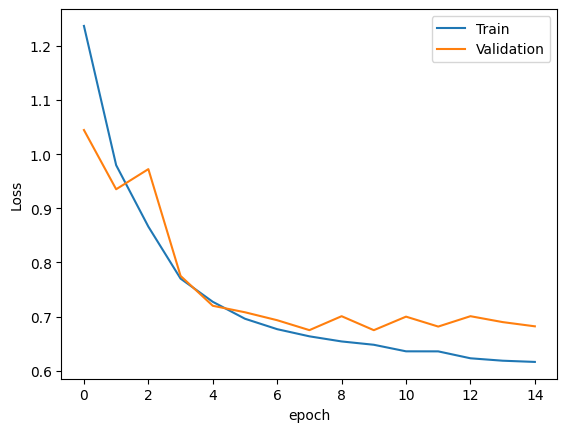

In [ ]:
maxEpoch = 15
# DO NOT RUN AGAIN
# initial trainloader is already in batches of 10
train_and_graph(model, trainloader25, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 97.77%   P = 0.93   R = 0.98
TumorArea Accuracy = 27.55%   P = 0.56   R = 0.28
HealthyArea Accuracy = 67.93%   P = 0.53   R = 0.68
EyesClosed Accuracy = 76.27%   P = 0.79   R = 0.76
EyesOpen Accuracy = 82.68%   P = 0.68   R = 0.83
-----------------------------------------------------
Overall Accuracy: 70.75%
Overall Precision: 0.70
Overall Recall: 0.71

Validation Dataset Accuracy: 
Seizure Accuracy = 95.88%   P = 0.93   R = 0.96
TumorArea Accuracy = 24.79%   P = 0.53   R = 0.25
HealthyArea Accuracy = 65.62%   P = 0.50   R = 0.66
EyesClosed Accuracy = 75.43%   P = 0.77   R = 0.75
EyesOpen Accuracy = 79.04%   P = 0.65   R = 0.79
-----------------------------------------------------
Overall Accuracy: 67.13%
Overall Precision: 0.67
Overall Recall: 0.67


## <font color= 'black'> Batch Size: 15
Training Accuracy: 73.59%
Validation Accuracy: 69.22%
- Runtime is lower than batch size 10, with remarkably similar results! (22 seconds vs. 39 seconds)

Will continue to use batch size 15 in rest of experimentation

In [ ]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

In [ ]:
# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# make batch size from train dataset csv
trainloader15 = csv_to_dataloader("train_data.csv", 15, False)

# checking batch size
print("Verfying Batch Size!")
for batch_idx, (inputs, targets) in enumerate(trainloader15):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)
  break  # Stop the loop after processing one batch

Verfying Batch Size!
Batch 0:
Inputs shape: torch.Size([15, 178, 1])
Targets shape: torch.Size([15])


Finished Training
Runtime:  22.06745409965515


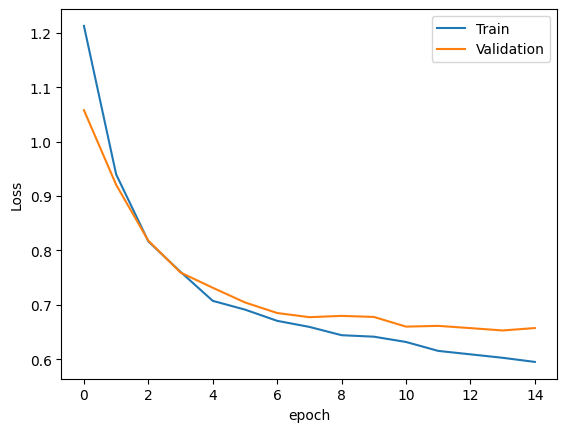

In [ ]:
maxEpoch = 15
# DO NOT RUN AGAIN
# initial trainloader is already in batches of 10
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 95.68%   P = 0.97   R = 0.96
TumorArea Accuracy = 34.83%   P = 0.65   R = 0.35
HealthyArea Accuracy = 76.90%   P = 0.56   R = 0.77
EyesClosed Accuracy = 72.07%   P = 0.86   R = 0.72
EyesOpen Accuracy = 87.12%   P = 0.69   R = 0.87
-----------------------------------------------------
Overall Accuracy: 73.59%
Overall Precision: 0.75
Overall Recall: 0.74

Validation Dataset Accuracy: 
Seizure Accuracy = 94.43%   P = 0.96   R = 0.94
TumorArea Accuracy = 30.99%   P = 0.59   R = 0.31
HealthyArea Accuracy = 71.70%   P = 0.52   R = 0.72
EyesClosed Accuracy = 70.30%   P = 0.84   R = 0.70
EyesOpen Accuracy = 83.19%   P = 0.65   R = 0.83
-----------------------------------------------------
Overall Accuracy: 69.22%
Overall Precision: 0.70
Overall Recall: 0.69


# <font color= 'blue'> Experiment 4: Addition of Layers
(2 layers were used in previous experiment)
- 4 layers
- 5 layers

*Reminder of Constants:* GRU Cell, Dropout = 0.5, Hidden_Size = 32, Batch Size = 15, Epochs = 15

*Results:*
Runtime only increased by few seconds.
Overall accuracy did not change much, but accuracy of Tumor Area class had significant improvement with 4 layer network (30% to 45%)
**For this experiment, having more balance in accuracy between classes is preferred for optimal performance.**

## 4 layers
Training Accuracy: 71.80%
Validation Accuracy: 68.61%
- runtime did not increase significantly (+3 seconds)
- **Tumor Area accuracy significantly increased from 2 layer network (30% to 45%)**.

In [ ]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=4, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
trainloader15 = csv_to_dataloader("train_data.csv", 15, False)

# checking batch size
print("Verfying Batch Size!")
for batch_idx, (inputs, targets) in enumerate(trainloader15):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)
  break  # Stop the loop after processing one batch

Verfying Batch Size!
Batch 0:
Inputs shape: torch.Size([15, 178, 1])
Targets shape: torch.Size([15])


Finished Training
Runtime:  25.573824167251587


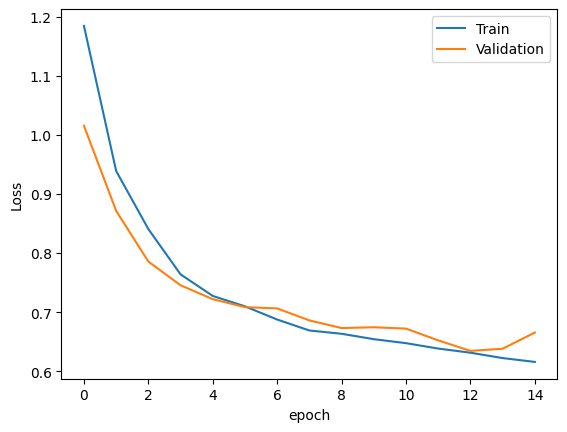

In [ ]:
maxEpoch = 15
# trainloader15 = csv_to_dataloader("train_data.csv", 15, False)
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 98.33%   P = 0.91   R = 0.98
TumorArea Accuracy = 49.30%   P = 0.57   R = 0.49
HealthyArea Accuracy = 62.46%   P = 0.55   R = 0.62
EyesClosed Accuracy = 73.84%   P = 0.80   R = 0.74
EyesOpen Accuracy = 73.65%   P = 0.75   R = 0.74
-----------------------------------------------------
Overall Accuracy: 71.80%

Validation Dataset Accuracy: 
Seizure Accuracy = 97.82%   P = 0.90   R = 0.98
TumorArea Accuracy = 45.45%   P = 0.55   R = 0.45
HealthyArea Accuracy = 61.43%   P = 0.51   R = 0.61
EyesClosed Accuracy = 72.65%   P = 0.80   R = 0.73
EyesOpen Accuracy = 70.09%   P = 0.72   R = 0.70
-----------------------------------------------------
Overall Accuracy: 68.61%


## 5 layers
Training Accuracy: 71.52%
Validation Accuracy: 68.74%
- runtime did not increase significantly from 4 layers (+4 seconds)
- similar overall accuracy to 4 layer, yet **Tumor Area accuracy significantly decreased from 4 layer network (45% to 19%).**

In [ ]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=5, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=32, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  29.703065633773804


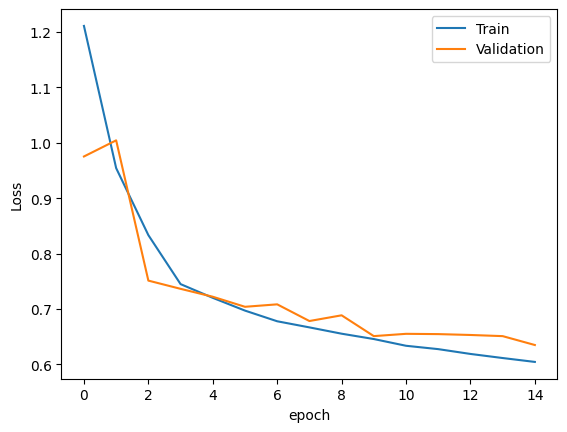

In [ ]:
maxEpoch = 15
# trainloader15 = csv_to_dataloader("train_data.csv", 15, False)
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 97.63%   P = 0.94   R = 0.98
TumorArea Accuracy = 21.75%   P = 0.64   R = 0.22
HealthyArea Accuracy = 80.10%   P = 0.53   R = 0.80
EyesClosed Accuracy = 82.61%   P = 0.74   R = 0.83
EyesOpen Accuracy = 74.02%   P = 0.73   R = 0.74
-----------------------------------------------------
Overall Accuracy: 71.52%

Validation Dataset Accuracy: 
Seizure Accuracy = 97.34%   P = 0.94   R = 0.97
TumorArea Accuracy = 19.01%   P = 0.65   R = 0.19
HealthyArea Accuracy = 80.08%   P = 0.51   R = 0.80
EyesClosed Accuracy = 82.48%   P = 0.75   R = 0.82
EyesOpen Accuracy = 69.65%   P = 0.69   R = 0.70
-----------------------------------------------------
Overall Accuracy: 68.74%


# <font color= 'blue'> Experiment 5: Hidden Size & Epochs
increased epochs to 20 to better observe effect, but later had to decrease due to overfitting occuring towards end of epochs

max hidden size possible: 178

(hidden size 32 used in previous experiments)
- Hidden size 48, 20 epochs
- Hidden size 40, 20 epochs
- Hidden size 28, 15 epochs

*Results:* Difficult to make conclusions on runtime due to changes in epochs.
Increasing or decreasing both the hidden size did not significantly increase accuracy. **In fact, the classes became more imbalanced (ex: Tumor Area accuracy significantly decreased for all changes in hidden size).**
Will continue using hidden size 32 from previous experiments.

***Will not be increasing epochs in future experiment due to overfitting occuring towards 15th epoch***, as observed in current experiment

## Hidden Size: 48, Epochs = 20
Training Accuracy: 73.52%
Validation Accuracy: 68.74%
Lots of excess overfitting. Will try decreasing hidden size. Runtime inccreased x2 from hidden size 32 (5 epoch increase not accounted for).

In [ ]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=48, num_layers=5, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=48, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  43.891889333724976


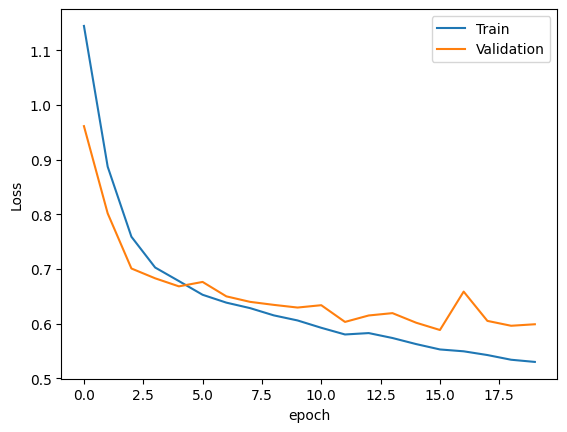

In [ ]:
maxEpoch = 20
# trainloader15 = csv_to_dataloader("train_data.csv", 15, False)
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 94.01%   P = 0.96   R = 0.94
TumorArea Accuracy = 39.16%   P = 0.63   R = 0.39
HealthyArea Accuracy = 74.56%   P = 0.57   R = 0.75
EyesClosed Accuracy = 81.13%   P = 0.77   R = 0.81
EyesOpen Accuracy = 78.38%   P = 0.75   R = 0.78
-----------------------------------------------------
Overall Accuracy: 73.68%

Validation Dataset Accuracy: 
Seizure Accuracy = 92.49%   P = 0.95   R = 0.92
TumorArea Accuracy = 33.06%   P = 0.54   R = 0.33
HealthyArea Accuracy = 69.81%   P = 0.52   R = 0.70
EyesClosed Accuracy = 79.91%   P = 0.76   R = 0.80
EyesOpen Accuracy = 74.67%   P = 0.72   R = 0.75
-----------------------------------------------------
Overall Accuracy: 69.17%


## Hidden Size: 40, Epochs = 20
Training Accuracy: 73.94%
Validation Accuracy: 70.39%

More overfitting towards end of run. **Tumor Area accuracy decreased, from 45% in hidden state 32 to 38%**.
Maybe hidden size should be decreased to below 32? Switch epochs back to 15, since more overfitting happens past 15th epoch?

In [ ]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=40, num_layers=5, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=40, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  37.67571258544922


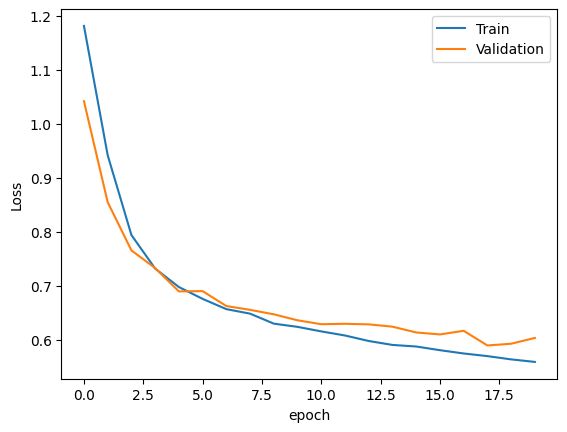

In [ ]:
maxEpoch = 20
# trainloader15 = csv_to_dataloader("train_data.csv", 15, False)
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 96.38%   P = 0.97   R = 0.96
TumorArea Accuracy = 41.29%   P = 0.66   R = 0.41
HealthyArea Accuracy = 72.38%   P = 0.58   R = 0.72
EyesClosed Accuracy = 83.86%   P = 0.74   R = 0.84
EyesOpen Accuracy = 74.60%   P = 0.75   R = 0.75
-----------------------------------------------------
Overall Accuracy: 73.94%

Validation Dataset Accuracy: 
Seizure Accuracy = 94.43%   P = 0.96   R = 0.94
TumorArea Accuracy = 38.64%   P = 0.59   R = 0.39
HealthyArea Accuracy = 68.13%   P = 0.55   R = 0.68
EyesClosed Accuracy = 83.55%   P = 0.74   R = 0.84
EyesOpen Accuracy = 71.18%   P = 0.72   R = 0.71
-----------------------------------------------------
Overall Accuracy: 70.39%


## Hidden Size: 28, Epochs = 15
Training Accuracy: 70.39%
Validation Accuracy: 67.65%

Overfitting reduced from other changes in hidden size, but Tumor Area accuracy decreased from hidden size 32 accuracy (45% to 25%).
Interestingly, there was an increase in runtime from hidden size 32 to hidden size 28.

In [ ]:
class RecurNet(nn.Module):
    def __init__(self):
        super(RecurNet, self).__init__()
        self.rnn = nn.GRU(input_size=1, hidden_size=28, num_layers=5, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
        # nn.GRUCell used for constructing complex architecture between gru layers

        self.fc = nn.Linear(in_features=28, out_features=5)
        # in_features --> should match hidden_size
        # out_features --> should match number of categories/classes to classify with

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

model = RecurNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  27.799922704696655


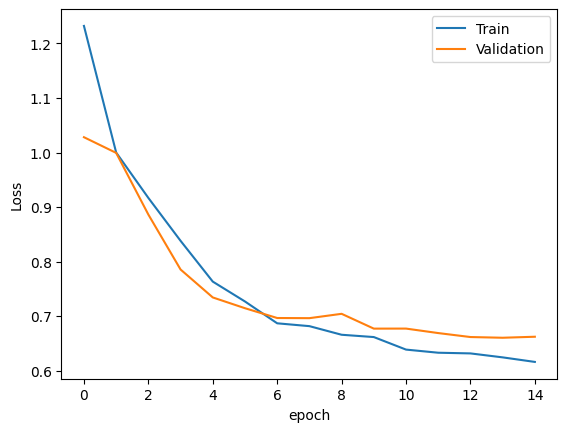

In [ ]:
maxEpoch = 15
# trainloader15 = csv_to_dataloader("train_data.csv", 15, False)
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 94.29%   P = 0.97   R = 0.94
TumorArea Accuracy = 22.85%   P = 0.61   R = 0.23
HealthyArea Accuracy = 73.69%   P = 0.54   R = 0.74
EyesClosed Accuracy = 79.37%   P = 0.74   R = 0.79
EyesOpen Accuracy = 80.35%   P = 0.67   R = 0.80
-----------------------------------------------------
Overall Accuracy: 70.39%

Validation Dataset Accuracy: 
Seizure Accuracy = 94.67%   P = 0.96   R = 0.95
TumorArea Accuracy = 19.63%   P = 0.60   R = 0.20
HealthyArea Accuracy = 72.33%   P = 0.51   R = 0.72
EyesClosed Accuracy = 77.78%   P = 0.76   R = 0.78
EyesOpen Accuracy = 78.82%   P = 0.62   R = 0.79
-----------------------------------------------------
Overall Accuracy: 67.65%


# <font color= 'blue'> Experiment 6: Effect of weight initalization
- purposefully added after complex archiecture optimization to see if weight intalization makes a difference after such changes
- used Xavier initalization. Xavier initalization is also known as Glorot initalization, and is usually used with hyperbolic tan() activation

*Results:* Accuracy improved! **Xavier initalization seems to add more noise to the model and allows the model to better balance out the classes.** Tumor Area accuracy increased (45% to 51%).

Training Accuracy: 74.22%
Validation Accuracy: 71.48%

*Finalized Model Architecture:*
GRU Cell, Dropout = 0.5, Layers = 4, Hidden_Size = 32, Batch Size = 15, Epochs = 15, Xavier Initalization

In [ ]:
class RecurNet(nn.Module):
  def __init__(self):
    super(RecurNet, self).__init__()
    self.rnn = nn.GRU(input_size=1, hidden_size=32, num_layers=4, batch_first=True, dropout=0.5) # can use multiple layers for num_layers of gru
    # nn.GRUCell used for constructing complex architecture between gru layers

    self.fc = nn.Linear(in_features=32, out_features=5)
    # in_features --> should match hidden_size
    # out_features --> should match number of categories/classes to classify with

    # Initialize the parameters using Xavier initialization
    self.init_weights()

  def init_weights(self):
    for name, param in self.named_parameters():
      if 'weight' in name:
        init.xavier_uniform_(param)
      elif 'bias' in name:
        init.constant_(param, 0.0)

  def forward(self, x):
    x, _ = self.rnn(x)
    x = self.fc(x[:, -1, :])
    return x

model = RecurNet()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Finished Training
Runtime:  25.009180784225464


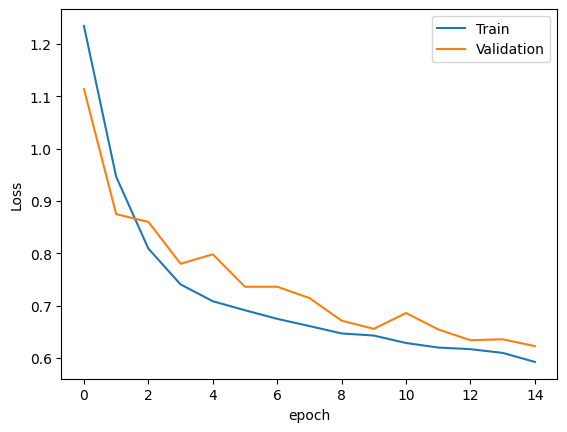

In [ ]:
maxEpoch = 15
trainloader15 = csv_to_dataloader("train_data.csv", 15, False)
train_and_graph(model, trainloader15, validloader, maxEpoch, criterion, optimizer)

In [ ]:
print("Training Dataset Accuracy: ")
get_accuracy_RP(model, classes, trainloader)
print()
print("Validation Dataset Accuracy: ")
get_accuracy_RP(model, classes, validloader)

Training Dataset Accuracy: 
Seizure Accuracy = 97.14%   P = 0.95   R = 0.97
TumorArea Accuracy = 54.08%   P = 0.63   R = 0.54
HealthyArea Accuracy = 65.23%   P = 0.59   R = 0.65
EyesClosed Accuracy = 77.23%   P = 0.80   R = 0.77
EyesOpen Accuracy = 76.20%   P = 0.73   R = 0.76
-----------------------------------------------------
Overall Accuracy: 74.22%

Validation Dataset Accuracy: 
Seizure Accuracy = 96.13%   P = 0.94   R = 0.96
TumorArea Accuracy = 51.03%   P = 0.63   R = 0.51
HealthyArea Accuracy = 62.89%   P = 0.55   R = 0.63
EyesClosed Accuracy = 76.28%   P = 0.80   R = 0.76
EyesOpen Accuracy = 74.89%   P = 0.68   R = 0.75
-----------------------------------------------------
Overall Accuracy: 71.48%


# <font color= 'blue'> Classifying Test Dataset!
## overall accuracy: 71.65%
## training runtime: 25 seconds
*Class Accuracy Breakdown:*
- Seizure: 94.90%
- Tumor Area: 54.07%
- Healthy Area: 60.09%
- Eyes Closed: 77.68%
- Eyes Open: 71.58%

*Finalized Model Architecture:*
- GRU Cell
- Xavier Initalizaiton
- Dropout = 0.5
- Layers = 4
- Hidden_Size = 32
- Batch Size = 15
- Epochs = 15

In [ ]:
# make batch size from test dataset csv
testloader15 = csv_to_dataloader("test_data.csv", 15, False)

# checking batch size
print("Verfying Batch Size!")
for batch_idx, (inputs, targets) in enumerate(testloader15):
  print(f"Batch {batch_idx}:")
  print("Inputs shape:", inputs.shape)
  print("Targets shape:", targets.shape)
  break  # Stop the loop after processing one batch

Verfying Batch Size!
Batch 0:
Inputs shape: torch.Size([15, 178, 1])
Targets shape: torch.Size([15])


In [ ]:
print("Testing Dataset Accuracy: ")
get_accuracy_RP(model, classes, testloader15)
print()

Testing Dataset Accuracy: 
Seizure Accuracy = 93.13%   P = 0.97   R = 0.93
TumorArea Accuracy = 37.58%   P = 0.63   R = 0.38
HealthyArea Accuracy = 70.07%   P = 0.55   R = 0.70
EyesClosed Accuracy = 80.00%   P = 0.74   R = 0.80
EyesOpen Accuracy = 77.14%   P = 0.71   R = 0.77
-----------------------------------------------------
Overall Accuracy: 71.65%



# <font color= 'blue'> Evaluation
Note: no individual experiment graph for experiment 1 or 2 (determined to be unnecessary)

Figure 1) <font color= 'blue'> *Best Experiment Model vs. Accuracy & Runtime*

Compares all experiments, excluding experiment 5 since no model variation was found in the experiment.

Figure 2) <font color= 'blue'> *Experiment 3: Batch Size vs. Accuracy & Runtime*

Runtime decreases with increase in batch size

Figure 3) <font color= 'blue'> *Experiment 4: Number of Layers vs. Accuracy & Runtime*

Runtime increases with increase in number of layers; **overall** accuracy does not significantly change.

Figure 4 & 5) <font color= 'blue'> *Experiment 4: Number of Layers vs. Class Accuracies*

Shows distribution of accuracies between classes to highlight differences between layers. This was the reasoning for selection of the model. Graph also allows for identification of overfitting trends by classification.

Figure 6) <font color= 'blue'> *Experiment 5: Hidden Size vs. Accuracy & Runtime*

Shows trend of slight accuracy shift, yet large runtime change. However, it is difficult to make true conclusions on runtime since hidden sizes of 48 and 40 were run on 20 epochs and hidden sizes of 32 and 28 were run on 15 epochs to mitigate overfitting. Hidden size 32 has least overfitting overall.

Figure 6 & 7) <font color= 'blue'> *Experiment 5: Hidden Size vs. Class Accuracies*

Distribution of accuracies between classes was interesting in this experiment, highlights the need for optimization of hidden size since hidden sizes above and below 32 had class accuracy distributions that had a higher variance (via standard deviation).

Figure 8) <font color= 'blue'> *Experiment 6: Weight Intialization vs. Accuracy & Runtime*

Xavier intialization has slightly lower runtime than random intialization, although difference is most likely not statistically significant.

Figure 8 & 9) <font color= 'blue'> *Experiment 6: Weight Intialization vs. Class Accuracies*

Shows distribution of accuracies between classes since Xavier weight intialization aided in balance between class accuracies.

In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Best experiment model vs. accuracy & runtime

In [ ]:
!pip install matplotlib

<Figure size 640x480 with 0 Axes>

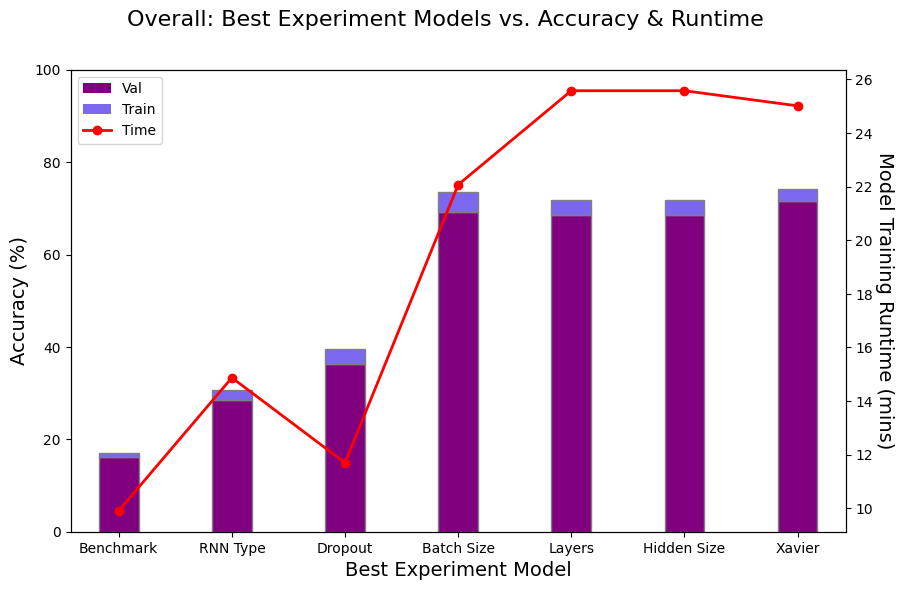

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure()
width = 0.35  # width of a bar

xLabels = ["Benchmark", 'RNN Type', 'Dropout', 'Batch Size', 'Layers', 'Hidden Size', 'Xavier']

#xLabels = ["Benchmark", 'Exp. 1', 'Exp. 2', 'Exp. 3', 'Exp. 4', 'Exp. 5', 'Exp. 6']
data = pd.DataFrame({
    'Experiment': xLabels,
    'Train Accuracy': [17.03, 30.58, 39.51, 73.59, 71.80, 71.80, 74.22],
    'Val Accuracy': [16.23, 28.43, 36.35, 69.22, 68.61, 68.61, 71.48],
    'Train Runtime': [9.91, 14.87, 11.698, 22.067, 25.573, 25.573, 25.009]
})

# calculate diff
data['Train Accuracy Diff'] = data['Train Accuracy'] - data['Val Accuracy']

#original size (10, 6)
fig, ax = plt.subplots(figsize=(10, 6)) # create fig + axes


# plotting. note: secondary axis!!
data['Val Accuracy'].plot(kind='bar', width=width, ax=ax, color='purple', edgecolor='gray', label='Val Accuracy')
data['Train Accuracy Diff'].plot(kind='bar', width=width, ax=ax, bottom=data['Val Accuracy'], color='mediumslateblue', edgecolor='gray', label='Train Accuracy')
data['Train Runtime'].plot(secondary_y=True, color='red', linewidth=2, linestyle='-', marker='o', ax=ax)


# labels
ax.set_xticklabels(xLabels, fontsize=10)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Best Experiment Model', fontsize=14)
ax.right_ax.set_ylabel('Model Training Runtime (mins)', rotation=-90, labelpad=15, fontsize=14)


ax.set_ylim(0, 100) # y axis scale


# Create legend manually --> had to do manually because of the dual graphs being used
line1, = ax.plot([], [], color='red', linewidth=2, linestyle='-', marker='o', label='Train Runtime')
bar1_proxy = plt.Rectangle((0,0),1,1,fc="purple", edgecolor = 'none')
bar2_proxy = plt.Rectangle((0,0),1,1,fc='mediumslateblue', edgecolor = 'none')
ax.legend([bar1_proxy, bar2_proxy, line1], ['Val', 'Train', 'Time'], loc='upper left')

plt.suptitle('Overall: Best Experiment Models vs. Accuracy & Runtime', fontsize=16)

plt.savefig('overall_plot.png', dpi=300) # save
plt.show() # show

## Experiment 3: batch size vs. runtime & accuracy

<Figure size 640x480 with 0 Axes>

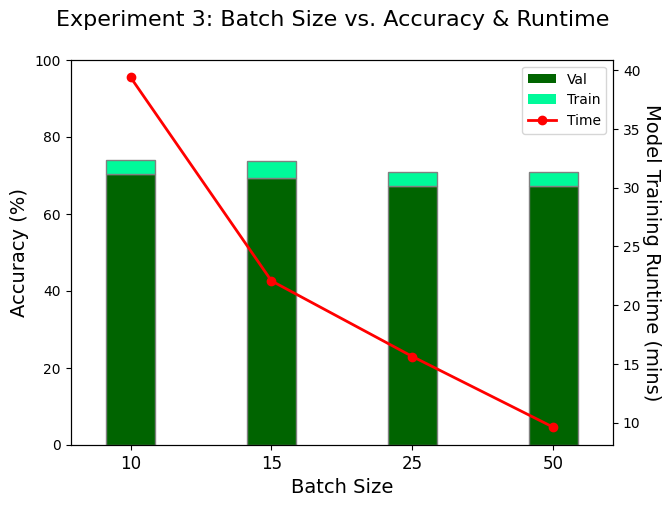

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure()
width = 0.35  # width of a bar

data = pd.DataFrame({
    'Batch Size': ['10', '15', '25', '50'],
    'Train Accuracy': [74,  73.59, 70.75, 70.75],
    'Val Accuracy': [70.26, 69.22, 67.13, 67.17],
    'Train Runtime': [39.4, 22.06, 15.62, 9.6]
})

# calculate diff
data['Train Accuracy Diff'] = data['Train Accuracy'] - data['Val Accuracy']

fig, ax = plt.subplots(figsize=(7, 5)) # create fig + axes

# plotting. note: secondary axis!!
data['Val Accuracy'].plot(kind='bar', width=width, ax=ax, color='darkgreen', edgecolor="gray", label='Val Accuracy')
data['Train Accuracy Diff'].plot(kind='bar', width=width, ax=ax, bottom=data['Val Accuracy'], edgecolor='gray', color='mediumspringgreen', label='Train Accuracy')
data['Train Runtime'].plot(secondary_y=True, color='red', label='Runtime', linewidth=2, linestyle='-', marker='o', ax=ax)

# labels
ax.set_xticklabels(('10', '15', '25', '50'), fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Batch Size', fontsize=14)
ax.right_ax.set_ylabel('Model Training Runtime (mins)', rotation=-90, labelpad=15, fontsize=14)

ax.set_ylim(0, 100) # y axis scale
ax.legend(loc='upper right') # show legend

# Create legend manually --> had to do manually because of the dual graphs being used
line1, = ax.plot([], [], color='red', linewidth=2, linestyle='-', marker='o', label='Train Runtime')
bar1_proxy = plt.Rectangle((0,0),1,1,fc="darkgreen", edgecolor = 'none')
bar2_proxy = plt.Rectangle((0,0),1,1,fc='mediumspringgreen', edgecolor = 'none')
ax.legend([bar1_proxy, bar2_proxy, line1], ['Val', 'Train', 'Time'], loc='upper right')


plt.suptitle('Experiment 3: Batch Size vs. Accuracy & Runtime', fontsize=16)

plt.savefig('exp3_overall_plot.png', dpi=300) # save
plt.show() # show

## Experiment 4: number of layers vs. accuracy & runtime

<Figure size 640x480 with 0 Axes>

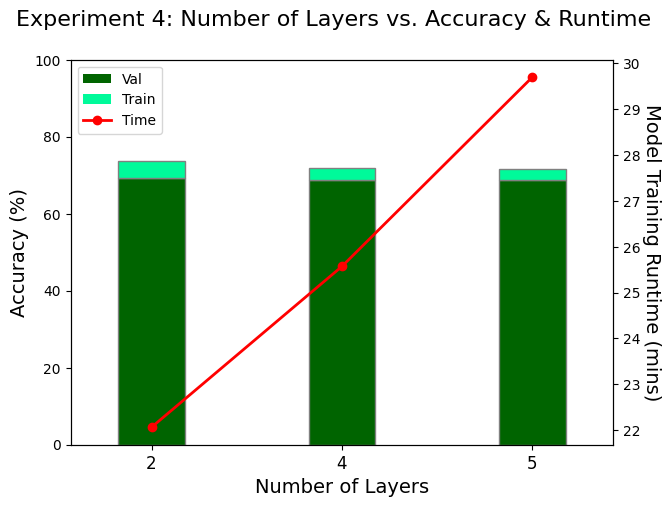

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure()
width = 0.35  # width of a bar

xLabels = ['2', '4', '5']
data = pd.DataFrame({
    'Layers': xLabels,
    'Train Accuracy': [73.59,  71.80, 71.52],
    'Val Accuracy': [69.22, 68.81, 68.74],
    'Train Runtime': [22.06, 25.57, 29.7],
})

# calculate diff
data['Train Accuracy Diff'] = data['Train Accuracy'] - data['Val Accuracy']

fig, ax = plt.subplots(figsize=(7, 5)) # create fig + axes

# plotting. note: secondary axis!!
data['Val Accuracy'].plot(kind='bar', width=width, ax=ax, color='darkgreen', edgecolor='gray', label='Val')
data['Train Accuracy Diff'].plot(kind='bar', width=width, ax=ax, bottom=data['Val Accuracy'], edgecolor='gray', color='mediumspringgreen', label='Train')
data['Train Runtime'].plot(secondary_y=True, color='red', label='Runtime', linewidth=2, linestyle='-', marker='o', ax=ax)


# labels
ax.set_xticklabels(xLabels, fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Number of Layers', fontsize=14)
ax.right_ax.set_ylabel('Model Training Runtime (mins)', rotation=-90, labelpad=15, fontsize=14)

ax.set_ylim(0, 100) # y axis scale
#ax.right_ax.set_ylim(0, 30) # secondary y axis scale
ax.legend(loc='upper right') # show legend

# Create legend manually --> had to do manually because of the dual graphs being used
line1, = ax.plot([], [], color='red', linewidth=2, linestyle='-', marker='o', label='Train Runtime')
bar1_proxy = plt.Rectangle((0,0),1,1,fc="darkgreen", edgecolor = 'none')
bar2_proxy = plt.Rectangle((0,0),1,1,fc='mediumspringgreen', edgecolor = 'none')
ax.legend([bar1_proxy, bar2_proxy, line1], ['Val', 'Train', 'Time'], loc='upper left')

plt.suptitle('Experiment 4: Number of Layers vs. Accuracy & Runtime', fontsize=16)

plt.savefig('exp4_overall_plot.png', dpi=300) # save
plt.show() # show

## Experiment 4: number of layers vs. class accuracies
[multiple graphs]

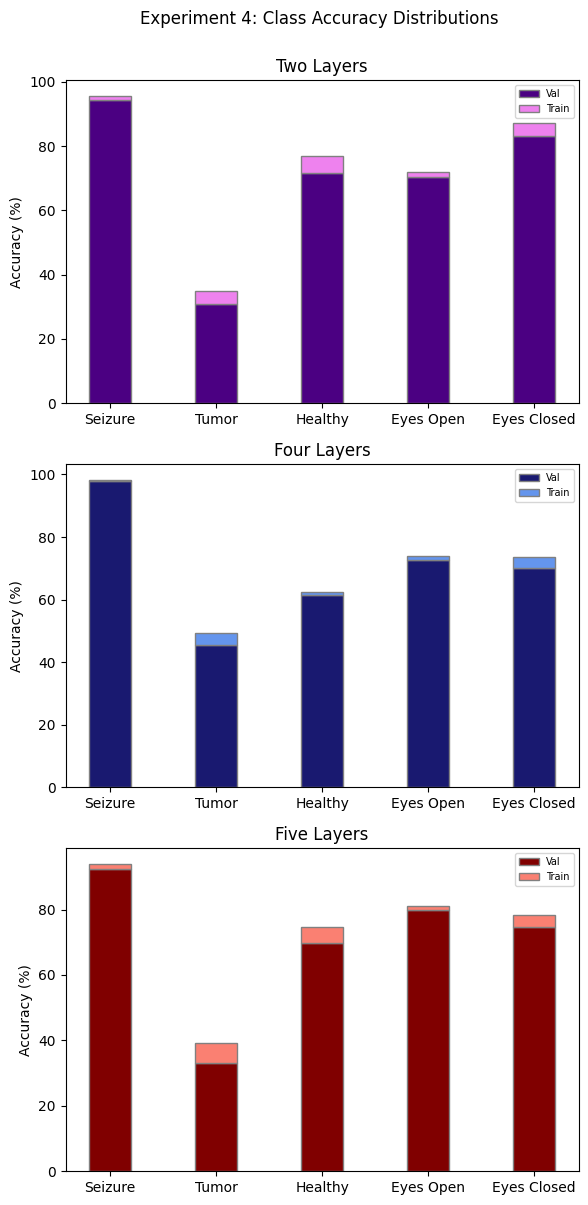

Standard Deviations for Class Accuracy Distributions [Training]:
2 Layers: 20.906336455725572
4 Layers: 16.152444520876706
5 Layers: 18.3468639282031


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
xClasses = ["Seizure", "Tumor", "Healthy", "Eyes Open", "Eyes Closed"]
layersTwoTrain = [95.66, 34.83, 76.90, 72.07, 87.12]; layersTwoVal = [94.43, 30.99, 71.70, 70.30, 83.19]
layersFourTrain = [98.33, 49.30, 62.46, 73.84, 73.65]; layersFourVal =  [97.82, 45.45, 61.43, 72.65, 70.09]
layersFiveTrain = [94.01, 39.16, 74.56, 81.13, 78.38]; layersFiveVal = [92.49, 33.06, 69.81, 79.91, 74.67]

# Compute the differences between training and validation accuracy
layersTwoDiff = np.array(layersTwoTrain) - np.array(layersTwoVal)
layersFourDiff = np.array(layersFourTrain) - np.array(layersFourVal)
layersFiveDiff = np.array(layersFiveTrain) - np.array(layersFiveVal)

# Define the width of the bars
bar_width = 0.40

# Set the positions for the bars
r = np.arange(len(xClasses))

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6,12)) # fig size = (width, height)

# Plotting for two layers
axs[0].bar(r, layersTwoVal, color='indigo', width=bar_width, edgecolor='grey', label='Val')
axs[0].bar(r, layersTwoDiff, bottom=layersTwoVal, color='violet', width=bar_width, edgecolor='grey', label='Train')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Two Layers')
axs[0].set_xticks(r)
axs[0].set_xticklabels(xClasses)
axs[0].legend(loc="upper right", fontsize=7)

# Plotting for four layers
axs[1].bar(r, layersFourVal, color='midnightblue', width=bar_width, edgecolor='grey', label='Val')
axs[1].bar(r, layersFourDiff, bottom=layersFourVal, color='cornflowerblue', width=bar_width, edgecolor='grey', label='Train')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Four Layers')
axs[1].set_xticks(r)
axs[1].set_xticklabels(xClasses)
axs[1].legend(loc="upper right", fontsize=7)

# Plotting for five layers
axs[2].bar(r, layersFiveVal, color='maroon', width=bar_width, edgecolor='grey', label='Val')
axs[2].bar(r, layersFiveDiff, bottom=layersFiveVal, color='salmon', width=bar_width, edgecolor='grey', label='Train')
axs[2].set_ylabel('Accuracy (%)')
axs[2].set_title('Five Layers')
axs[2].set_xticks(r)
axs[2].set_xticklabels(xClasses)
axs[2].legend(loc="upper right", fontsize=7)

# Add a centered title above the main title
plt.suptitle('Experiment 4: Class Accuracy Distributions', x=0.54, y=1.0, ha='center')

# ensure layout
plt.tight_layout()

plt.savefig('exp4_dis.png', dpi=300) # save
plt.show() # show


# Print standard deviations
print("Standard Deviations for Class Accuracy Distributions [Training]:")
print("2 Layers:", np.std(layersTwoTrain))
print("4 Layers:", np.std(layersFourTrain))
print("5 Layers:", np.std(layersFiveTrain))


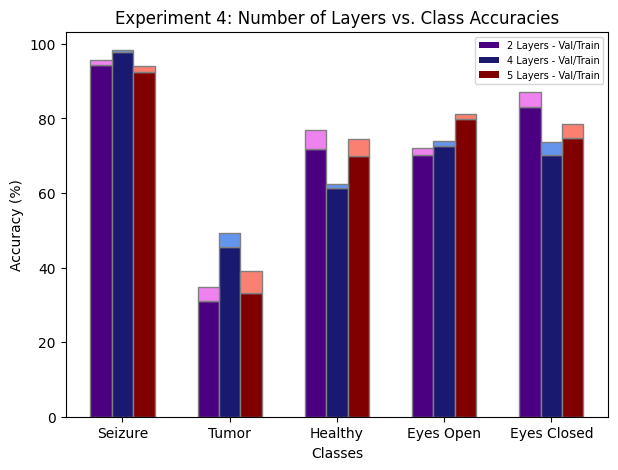

Standard Deviations for Class Accuracy Distributions [Training]:
2: 20.906336455725572
4: 16.152444520876706
5: 18.3468639282031


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
xClasses = ["Seizure", "Tumor", "Healthy", "Eyes Open", "Eyes Closed"]
layersTwoTrain = [95.66, 34.83, 76.90, 72.07, 87.12]; layersTwoVal = [94.43, 30.99, 71.70, 70.30, 83.19]
layersFourTrain = [98.33, 49.30, 62.46, 73.84, 73.65]; layersFourVal =  [97.82, 45.45, 61.43, 72.65, 70.09]
layersFiveTrain = [94.01, 39.16, 74.56, 81.13, 78.38]; layersFiveVal = [92.49, 33.06, 69.81, 79.91, 74.67]

# Compute the differences between training and validation accuracy
layersTwoDiff = np.array(layersTwoTrain) - np.array(layersTwoVal)
layersFourDiff = np.array(layersFourTrain) - np.array(layersFourVal)
layersFiveDiff = np.array(layersFiveTrain) - np.array(layersFiveVal)

# Compute standard deviations for train accuracies
layersTwoTrain_std = np.std(layersTwoTrain)
layersFourTrain_std = np.std(layersFourTrain)
layersFiveTrain_std = np.std(layersFiveTrain)

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars
r1 = np.arange(len(xClasses))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the plot
plt.figure(figsize= (7, 5)) # 10, 7
plt.bar(r1, layersTwoVal, color='indigo', width=bar_width, edgecolor='grey')
plt.bar(r2, layersFourVal, color='midnightblue', width=bar_width, edgecolor='grey')
plt.bar(r3, layersFiveVal, color='maroon', width=bar_width, edgecolor='grey')

plt.bar(r1, layersTwoDiff, bottom=layersTwoVal, color='violet', width=bar_width, edgecolor='grey')
plt.bar(r2, layersFourDiff, bottom=layersFourVal, color='cornflowerblue', width=bar_width, edgecolor='grey')
plt.bar(r3, layersFiveDiff, bottom=layersFiveVal, color='salmon', width=bar_width, edgecolor='grey')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Experiment 4: Number of Layers vs. Class Accuracies')
plt.xticks([r + bar_width for r in range(len(xClasses))], xClasses)

# legend
bar1_proxy = plt.Rectangle((0, 0), 1, 1, fc="indigo", edgecolor='none')
bar2_proxy = plt.Rectangle((0, 0), 1, 1, fc='midnightblue', edgecolor='none')
bar3_proxy = plt.Rectangle((0, 0), 1, 1, fc='maroon', edgecolor='none')
plt.legend(handles=[bar1_proxy, bar2_proxy, bar3_proxy], labels=['2 Layers - Val/Train', '4 Layers - Val/Train', '5 Layers - Val/Train'], loc='upper right', fontsize=7)

plt.savefig('exp4_comp_dis.png', dpi=300) # save
plt.show() # show

# Show plot
plt.show()

# Print standard deviations
print("Standard Deviations for Class Accuracy Distributions [Training]:")
print("2:", layersTwoTrain_std)
print("4:", layersFourTrain_std)
print("5:", layersFiveTrain_std)


## Experiment 5: hidden size vs. accuracy & runtime
note:
- hidden size 48 --> epoch 20
- hidden size 40 --> epoch 20
- hidden size 32 --> epoch 15
- hidden size 28 --> epoch 15

can also look at standard deviations from class accuracies, was difficult to spot a trend for balance of class accuracy.


<Figure size 640x480 with 0 Axes>

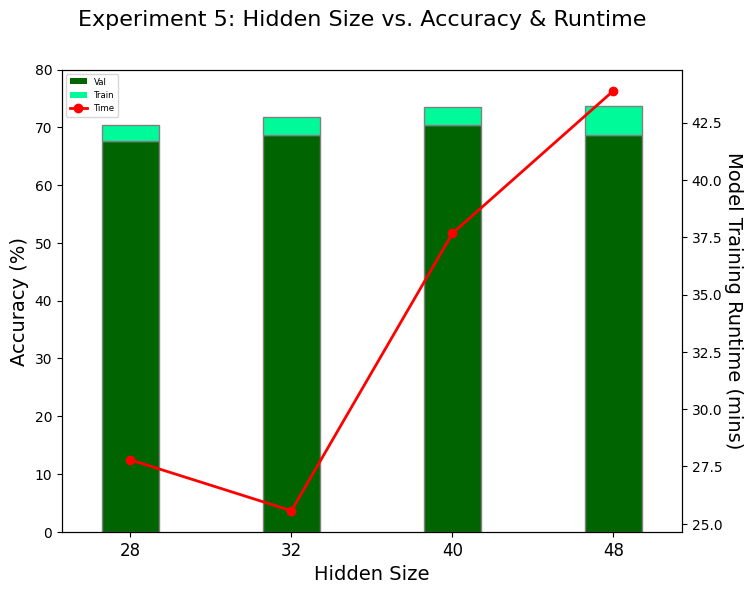

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure()
width = 0.35  # width of a bar

xLabels = ['28', '32', '40', '48']
data = pd.DataFrame({
    'Layers': xLabels,
    'Train Accuracy': [70.39,  71.80, 73.49, 73.72],
    'Val Accuracy': [67.65, 68.61, 70.39, 68.74],
    'Train Runtime': [27.79, 25.57, 37.67, 43.89],
})

# calculate diff
data['Train Accuracy Diff'] = data['Train Accuracy'] - data['Val Accuracy']

fig, ax = plt.subplots(figsize=(8, 6)) # create fig + axes

# plotting. note: secondary axis!!
data['Val Accuracy'].plot(kind='bar', width=width, ax=ax, color='darkgreen', edgecolor="grey", label='Val')
data['Train Accuracy Diff'].plot(kind='bar', width=width, ax=ax, bottom=data['Val Accuracy'], edgecolor="grey", color='mediumspringgreen', label='Train')
data['Train Runtime'].plot(secondary_y=True, color='red', label='Runtime', linewidth=2, linestyle='-', marker='o', ax=ax)

# labels
ax.set_xticklabels(xLabels, fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Hidden Size', fontsize=14)
ax.right_ax.set_ylabel('Model Training Runtime (mins)', rotation=-90, labelpad=15, fontsize=14)

ax.set_ylim(0, 80) # y axis scale
#ax.right_ax.set_ylim(0, 30) # secondary y axis scale

# Create legend manually --> had to do manually because of the dual graphs being used
line1, = ax.plot([], [], color='red', linewidth=2, linestyle='-', marker='o', label='Train Runtime')
bar1_proxy = plt.Rectangle((0,0),1,1,fc="darkgreen", edgecolor = 'none')
bar2_proxy = plt.Rectangle((0,0),1,1,fc='mediumspringgreen', edgecolor = 'none')
ax.legend([bar1_proxy, bar2_proxy, line1], ['Val', 'Train', 'Time'], loc='upper left', fontsize=6.2)

plt.suptitle('Experiment 5: Hidden Size vs. Accuracy & Runtime', fontsize=16)

plt.savefig('exp5_overall_plot.png', dpi=300) # save
plt.show() # show

## Experiment 5: hidden size vs. class accuracies
[multiple graphs]

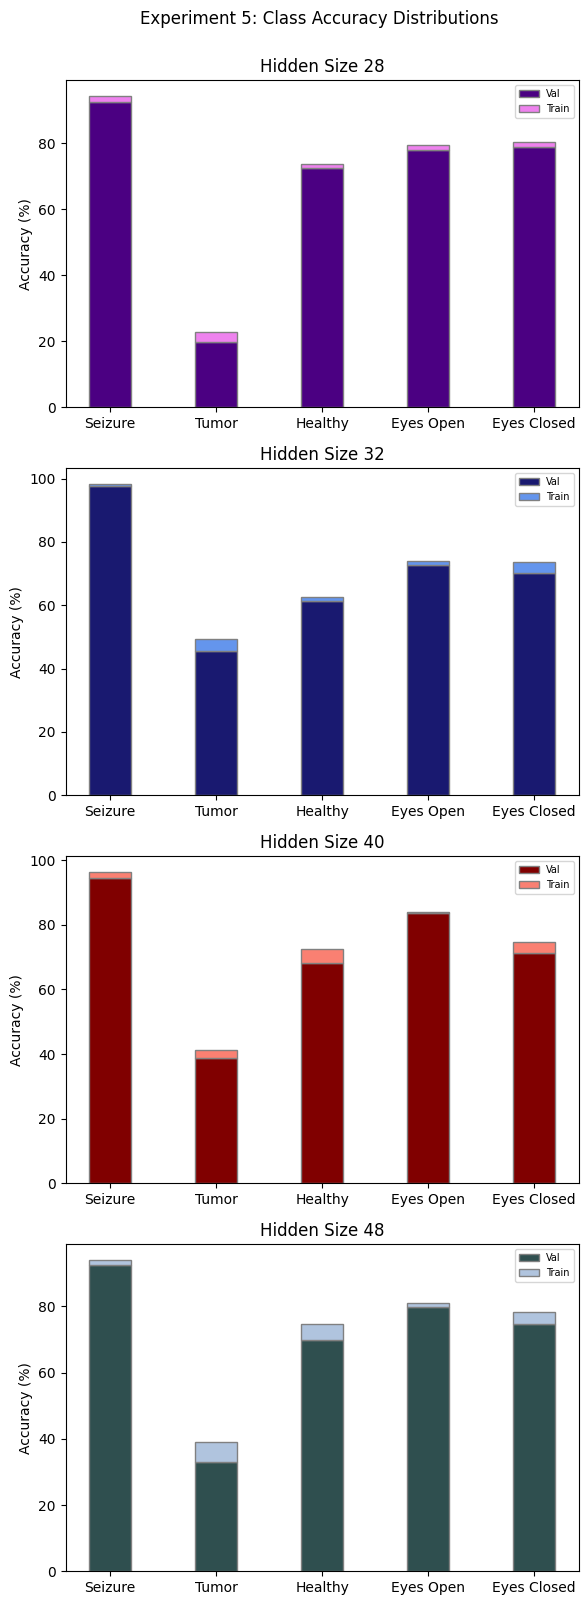

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
xClasses = ["Seizure", "Tumor", "Healthy", "Eyes Open", "Eyes Closed"]
s28_t = [94.29, 22.85, 73.69, 79.37, 80.35]; s28_v = [92.49, 19.63, 72.33, 77.78, 78.82]
s32_t = [98.33, 49.30, 62.46, 73.84, 73.65] ; s32_v = [97.82, 45.45, 61.43, 72.65, 70.09]
s40_t = [96.38, 41.29, 72.38, 83.86, 74.60]; s40_v = [94.43, 38.64, 68.13, 83.55, 71.18]
s48_t = [94.01, 39.16, 74.56, 81.13, 78.38]; s48_v = [92.49, 33.06, 69.81, 79.91, 74.67]

# Compute the differences between training and validation accuracy
s28_diff = np.array(s28_t) - np.array(s28_v)
s32_diff = np.array(s32_t) - np.array(s32_v)
s40_diff = np.array(s40_t) - np.array(s40_v)
s48_diff = np.array(s48_t) - np.array(s48_v)

# Define the width of the bars
bar_width = 0.40

# Set the positions for the bars
r = np.arange(len(xClasses))

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(6,16)) # fig size = (width, height)

# Plotting for size 28
axs[0].bar(r, s28_v, color='indigo', width=bar_width, edgecolor='grey', label='Val')
axs[0].bar(r, s28_diff, bottom=s28_v, color='violet', width=bar_width, edgecolor='grey', label='Train')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Hidden Size 28')
axs[0].set_xticks(r)
axs[0].set_xticklabels(xClasses)
axs[0].legend(loc="upper right", fontsize=7)

# Plotting for size 32
axs[1].bar(r, s32_v, color='midnightblue', width=bar_width, edgecolor='grey', label='Val')
axs[1].bar(r, s32_diff, bottom=s32_v, color='cornflowerblue', width=bar_width, edgecolor='grey', label='Train')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Hidden Size 32')
axs[1].set_xticks(r)
axs[1].set_xticklabels(xClasses)
axs[1].legend(loc="upper right", fontsize=7)

# Plotting for size 40
axs[2].bar(r, s40_v, color='maroon', width=bar_width, edgecolor='grey', label='Val')
axs[2].bar(r, s40_diff, bottom=s40_v, color='salmon', width=bar_width, edgecolor='grey', label='Train')
axs[2].set_ylabel('Accuracy (%)')
axs[2].set_title('Hidden Size 40')
axs[2].set_xticks(r)
axs[2].set_xticklabels(xClasses)
axs[2].legend(loc="upper right", fontsize=7)

# Plotting for size 48
axs[3].bar(r, s48_v, color='darkslategray', width=bar_width, edgecolor='grey', label='Val')
axs[3].bar(r, s48_diff, bottom=s48_v, color='lightsteelblue', width=bar_width, edgecolor='grey', label='Train')
axs[3].set_ylabel('Accuracy (%)')
axs[3].set_title('Hidden Size 48')
axs[3].set_xticks(r)
axs[3].set_xticklabels(xClasses)
axs[3].legend(loc="upper right", fontsize=7)

# Add a centered title above the main title
plt.suptitle('Experiment 5: Class Accuracy Distributions', x=0.54, y=1.0, ha='center')

# ensure layout
plt.tight_layout()

plt.savefig('exp5_dis.png', dpi=300) # save
plt.show() # show

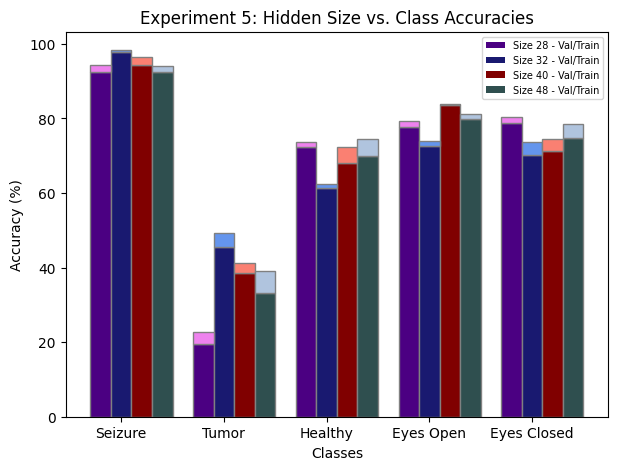

Standard Deviations for Class Accuracy Distributions [Training]:
Hidden Size 28: 24.582927409078035
Hidden Size 32: 16.152444520876706
Hidden Size 40: 18.27877720199029
Hidden Size 48: 18.3468639282031


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
xClasses = ["Seizure", "Tumor", "Healthy", "Eyes Open", "Eyes Closed"]
s28_t = [94.29, 22.85, 73.69, 79.37, 80.35]; s28_v = [92.49, 19.63, 72.33, 77.78, 78.82]
s32_t = [98.33, 49.30, 62.46, 73.84, 73.65]; s32_v = [97.82, 45.45, 61.43, 72.65, 70.09]
s40_t = [96.38, 41.29, 72.38, 83.86, 74.60]; s40_v = [94.43, 38.64, 68.13, 83.55, 71.18]
s48_t = [94.01, 39.16, 74.56, 81.13, 78.38]; s48_v = [92.49, 33.06, 69.81, 79.91, 74.67]

# Compute the differences between training and validation accuracy
s28_diff = np.array(s28_t) - np.array(s28_v)
s32_diff = np.array(s32_t) - np.array(s32_v)
s40_diff = np.array(s40_t) - np.array(s40_v)
s48_diff = np.array(s48_t) - np.array(s48_v)

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars
r1 = np.arange(len(xClasses))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize= (7, 5)) # 10, 7
plt.bar(r1, s28_v, color='indigo', width=bar_width, edgecolor='grey')
plt.bar(r2, s32_v, color='midnightblue', width=bar_width, edgecolor='grey')
plt.bar(r3, s40_v, color='maroon', width=bar_width, edgecolor='grey')
plt.bar(r4, s48_v, color='darkslategrey', width=bar_width, edgecolor='grey')

plt.bar(r1, s28_diff, bottom=s28_v, color='violet', width=bar_width, edgecolor='grey')
plt.bar(r2, s32_diff, bottom=s32_v, color='cornflowerblue', width=bar_width, edgecolor='grey')
plt.bar(r3, s40_diff, bottom=s40_v, color='salmon', width=bar_width, edgecolor='grey')
plt.bar(r4, s48_diff, bottom=s48_v, color='lightsteelblue', width=bar_width, edgecolor='grey')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Experiment 5: Hidden Size vs. Class Accuracies')
plt.xticks([r + bar_width for r in range(len(xClasses))], xClasses)

# legend
bar1_proxy = plt.Rectangle((0, 0), 1, 1, fc="indigo", edgecolor='none')
bar2_proxy = plt.Rectangle((0, 0), 1, 1, fc='midnightblue', edgecolor='none')
bar3_proxy = plt.Rectangle((0, 0), 1, 1, fc='maroon', edgecolor='none')
bar4_proxy = plt.Rectangle((0, 0), 1, 1, fc='darkslategrey', edgecolor='none')
plt.legend(handles=[bar1_proxy, bar2_proxy, bar3_proxy, bar4_proxy], labels=['Size 28 - Val/Train', 'Size 32 - Val/Train', 'Size 40 - Val/Train', 'Size 48 - Val/Train'], loc='upper right', fontsize=7)

plt.savefig('exp5_comp_dis.png', dpi=300) # save
plt.show() # show

# Show plot
plt.show()

# Print standard deviations
print("Standard Deviations for Class Accuracy Distributions [Training]:")
print("Hidden Size 28:", np.std(s28_t))
print("Hidden Size 32:", np.std(s32_t))
print("Hidden Size 40:", np.std(s40_t))
print("Hidden Size 48:", np.std(s48_t))

## Experiment 6: weight intialization vs. accuracy & runtime


<Figure size 640x480 with 0 Axes>

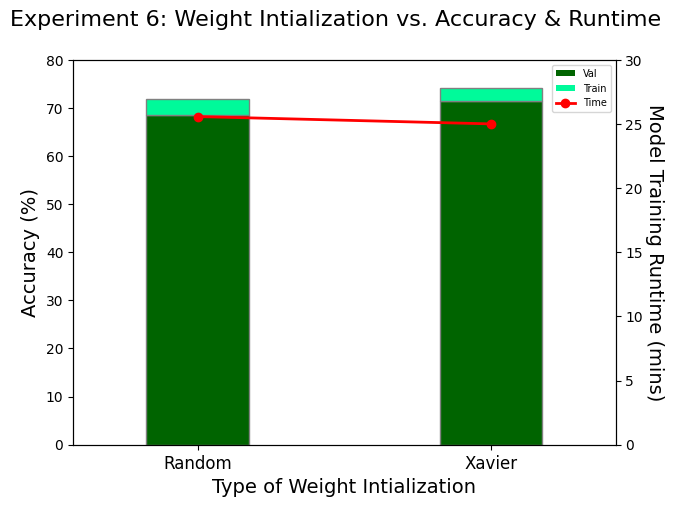

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('seaborn-v0_8-dark-palette')
plt.figure()
width = 0.35  # width of a bar

xLabels = ['Random', 'Xavier']
data = pd.DataFrame({
    'Layers': xLabels,
    'Train Accuracy': [71.80,  74.22],
    'Val Accuracy': [68.61, 71.48],
    'Train Runtime': [25.57, 25.0],
})

# calculate diff
data['Train Accuracy Diff'] = data['Train Accuracy'] - data['Val Accuracy']

fig, ax = plt.subplots(figsize=(7, 5)) # create fig + axes

# plotting. note: secondary axis!!
data['Val Accuracy'].plot(kind='bar', width=width, ax=ax, edgecolor='gray', color='darkgreen', label='Val')
data['Train Accuracy Diff'].plot(kind='bar', width=width, ax=ax, bottom=data['Val Accuracy'], edgecolor='grey', color='mediumspringgreen', label='Train')
data['Train Runtime'].plot(secondary_y=True, color='red', label='Runtime', linewidth=2, linestyle='-', marker='o', ax=ax)


# labels
ax.set_xticklabels(xLabels, fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=14)
ax.set_xlabel('Type of Weight Intialization', fontsize=14)
ax.right_ax.set_ylabel('Model Training Runtime (mins)', rotation=-90, labelpad=15, fontsize=14)

ax.set_ylim(0, 80) # y axis scale
ax.right_ax.set_ylim(0, 30) # secondary y axis scale

# Create legend manually --> had to do manually because of the dual graphs being used
line1, = ax.plot([], [], color='red', linewidth=2, linestyle='-', marker='o', label='Train Runtime')
bar1_proxy = plt.Rectangle((0,0),1,1,fc="darkgreen", edgecolor = 'none')
bar2_proxy = plt.Rectangle((0,0),1,1,fc='mediumspringgreen', edgecolor = 'none')
ax.legend([bar1_proxy, bar2_proxy, line1], ['Val', 'Train', 'Time'], loc='upper right', fontsize=7)


plt.suptitle('Experiment 6: Weight Intialization vs. Accuracy & Runtime', fontsize=16)

plt.savefig('exp6_overall_plot.png', dpi=300) # save
plt.show() # show

## Experiment 6: weight intialization vs. class accuracies
[multiple graphs]


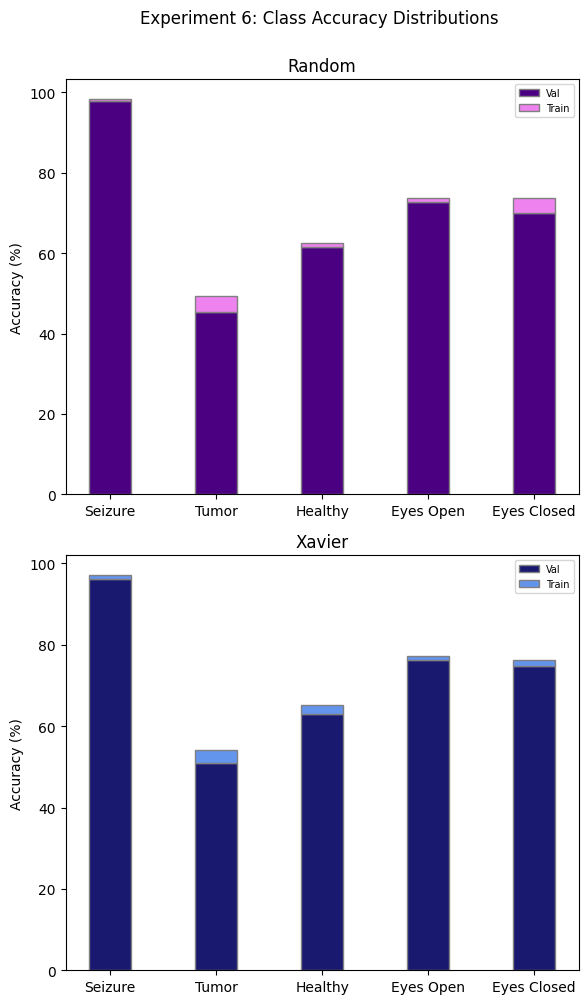

Standard Deviations for Class Accuracy [Training]:
Random: 16.152444520876706
Xavier: 14.313971636132301


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
xClasses = ["Seizure", "Tumor", "Healthy", "Eyes Open", "Eyes Closed"]
model_rand_t = [98.33, 49.30, 62.46, 73.84, 73.65]; model_rand_v = [97.82, 45.45, 61.43, 72.65, 70.09]
model_xavier_t = [97.14, 54.08, 65.23, 77.23, 76.20]; model_xavier_v =  [96.13, 51.03, 62.89, 76.28, 74.89] # xavier

# Compute the differences between training and validation accuracy
model_rand_diff = np.array(model_rand_t) - np.array(model_rand_v)
model_xavier_diff = np.array(model_xavier_t) - np.array(model_xavier_v)

# Define the width of the bars
bar_width = 0.40

# Set the positions for the bars
r = np.arange(len(xClasses))

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(6,10)) # fig size = (width, height)

# Plotting for random model
axs[0].bar(r, model_rand_v, color='indigo', width=bar_width, edgecolor='grey', label='Val')
axs[0].bar(r, model_rand_diff, bottom=model_rand_v, color='violet', width=bar_width, edgecolor='grey', label='Train')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Random')
axs[0].set_xticks(r)
axs[0].set_xticklabels(xClasses)
axs[0].legend(loc="upper right", fontsize=7)

# Plotting for xavier model
axs[1].bar(r, model_xavier_v, color='midnightblue', width=bar_width, edgecolor='grey', label='Val')
axs[1].bar(r, model_xavier_diff, bottom=model_xavier_v, color='cornflowerblue', width=bar_width, edgecolor='grey', label='Train')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Xavier')
axs[1].set_xticks(r)
axs[1].set_xticklabels(xClasses)
axs[1].legend(loc="upper right", fontsize=7)

# Add a centered title above the main title
plt.suptitle('Experiment 6: Class Accuracy Distributions', x=0.54, y=1.0, ha='center')

# Adjust layout
plt.tight_layout()

plt.savefig('exp6_dis.png', dpi=300) # save
plt.show() # show

# Print standard deviations
print("Standard Deviations for Class Accuracy [Training]:")
print("Random:", np.std(model_rand_t))
print("Xavier:", np.std(model_xavier_t))

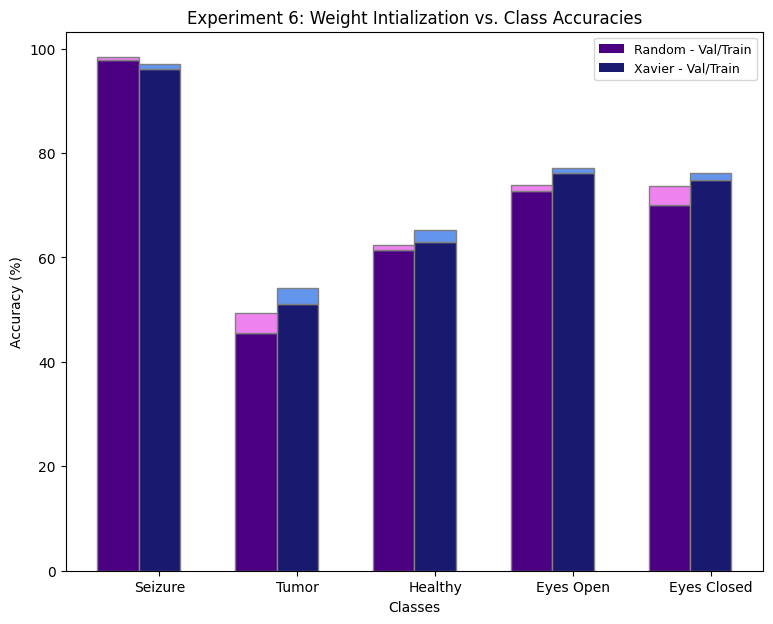

Standard Deviations for Class Accuracy [Training]:
Random: 16.152444520876706
Xavier: 14.313971636132301


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# data in previous cell

# Set the width of the bars
bar_width = 0.3

# Set the positions for the bars
r1 = np.arange(len(xClasses))
r2 = [x + bar_width for x in r1]

# Create the plot
plt.figure(figsize= (9, 7))
plt.bar(r1, model_rand_v, color='indigo', width=bar_width, edgecolor='grey', label='Random - Val Accuracy')
plt.bar(r2, model_xavier_v, color='midnightblue', width=bar_width, edgecolor='grey', label='Xavier - Val Accuracy')

plt.bar(r1, model_rand_diff, bottom=model_rand_v, color='violet', width=bar_width, edgecolor='grey', label='Random- Train Accuracy')
plt.bar(r2, model_xavier_diff, bottom=model_xavier_v, color='cornflowerblue', width=bar_width, edgecolor='grey', label='Xavier - Train Accuracy')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Experiment 6: Weight Intialization vs. Class Accuracies')
plt.xticks([r + bar_width for r in range(len(xClasses))], xClasses)

# legend
bar1_proxy = plt.Rectangle((0, 0), 1, 1, fc="indigo", edgecolor='none')
bar2_proxy = plt.Rectangle((0, 0), 1, 1, fc='midnightblue', edgecolor='none')
plt.legend(handles=[bar1_proxy, bar2_proxy, bar3_proxy], labels=['Random - Val/Train', 'Xavier - Val/Train'], loc='upper right', fontsize=9)

plt.savefig('exp6_comp_dis.png', dpi=300) # save
plt.show() # show

# Print standard deviations
print("Standard Deviations for Class Accuracy [Training]:")
print("Random:", np.std(model_rand_t))
print("Xavier:", np.std(model_xavier_t))

# <font color= 'blue'> Possible Future Experiments
- Use ensemble methods to futher increase accuracy from combining models that have balanced and imbalanced classes
- Experiment with different optimizers
- Implement a bidirectional RNN, compare LSTM and GRU again.
(Bidirectional RNNs are able to access past and future memory)